<a href="https://colab.research.google.com/github/utkarsh-prakash/Google-Colab-Notebooks/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import opendatasets as od
import pandas as pd

In [3]:
od.download("https://www.kaggle.com/datasets/puneet6060/intel-image-classification")

Skipping, found downloaded files in "./intel-image-classification" (use force=True to force download)


## Data Exploration

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import numpy as np

In [5]:
def get_random_training_image(training_data_path):
  path_list = list(os.walk(training_data_path))
  n_classes = len(path_list[0][1])
  print(f'Total Classes: {n_classes}')
  class_path = path_list[np.random.randint(1, n_classes + 1)]
  dir = class_path[0]
  filename = np.random.choice(class_path[2])
  image_path = os.path.join(dir, filename)
  img = mpimg.imread(image_path)
  imgplot = plt.imshow(img)
  print(f'Image Shape: {img.shape}')
  print(f'Image Class: {dir.split("/")[-1]}')


Total Classes: 6
Image Shape: (150, 150, 3)
Image Class: mountain


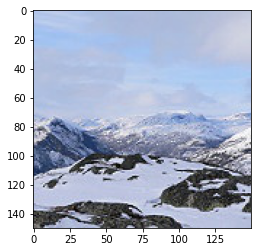

In [6]:
training_data_path = 'intel-image-classification/seg_train/seg_train/'
get_random_training_image(training_data_path)

In [7]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import tensorflow as tf
tf.__version__

'2.8.2'

In [9]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

## Training and evaluation on MobileNet V2

In [10]:
IMAGE_SIZE = [150,150,3]
BATCH_SIZE = 32

train_path = 'intel-image-classification/seg_train/seg_train/'
valid_path = 'intel-image-classification/seg_test/seg_test/'
train_class_folders = glob('intel-image-classification/seg_train/seg_train/*')
n_classes = len(train_class_folders)

In [11]:
mobilenet = MobileNetV2(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

In [12]:
for layer in mobilenet.layers:
    layer.trainable = False

In [13]:
i = tf.keras.layers.Input([150, 150, 3], dtype = tf.uint8)
x = tf.cast(i, tf.float32)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = mobilenet(x)

In [14]:
x = Flatten()(x)
prediction = Dense(n_classes, activation='softmax')(x)
model = Model(inputs=[i], outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [15]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [16]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_path,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMAGE_SIZE[:2],
                                                            label_mode='categorical')

Found 14034 files belonging to 6 classes.


In [17]:
test_dataset = tf.keras.utils.image_dataset_from_directory(valid_path,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMAGE_SIZE[:2],
                                                           label_mode='categorical')

Found 3000 files belonging to 6 classes.


In [18]:
run = model.fit(
  train_dataset,
  validation_data=test_dataset,
  epochs=5
)

Epoch 1/5
439/439 [==============================] - 284s 640ms/step - loss: 1.5631 - accuracy: 0.8616 - val_loss: 1.7093 - val_accuracy: 0.8807
Epoch 2/5
439/439 [==============================] - 258s 589ms/step - loss: 0.7565 - accuracy: 0.9292 - val_loss: 1.4152 - val_accuracy: 0.9017
Epoch 3/5
439/439 [==============================] - 264s 601ms/step - loss: 0.5058 - accuracy: 0.9511 - val_loss: 1.9326 - val_accuracy: 0.8967
Epoch 4/5
439/439 [==============================] - 262s 597ms/step - loss: 0.3646 - accuracy: 0.9621 - val_loss: 1.8509 - val_accuracy: 0.8990
Epoch 5/5
439/439 [==============================] - 260s 591ms/step - loss: 0.3231 - accuracy: 0.9684 - val_loss: 2.0949 - val_accuracy: 0.9007


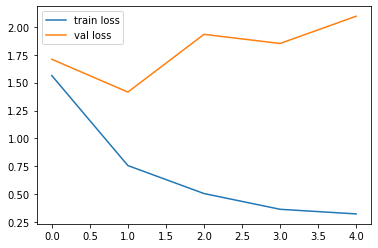

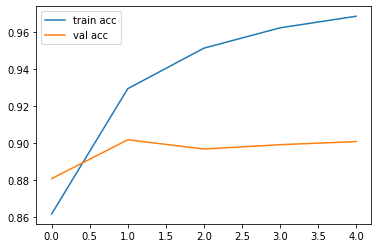

In [19]:
# plot the loss
plt.plot(run.history['loss'], label='train loss')
plt.plot(run.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(run.history['accuracy'], label='train acc')
plt.plot(run.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

## Inference

In [20]:
image_list = list(glob('intel-image-classification/seg_pred/seg_pred/*.jpg'))
class_names = train_dataset.class_names

In [21]:
def predict_random(image_list, class_names):
  image_path = np.random.choice(image_list)
  img = mpimg.imread(image_path)
  imgplot = plt.imshow(img)
  pred = model.predict(np.expand_dims(img,axis=0))
  print(f'model prediction : {class_names[pred.argmax()]}')

model prediction : forest


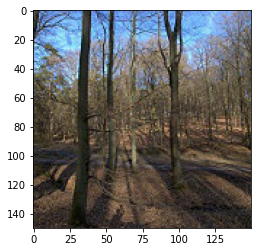

In [22]:
predict_random(image_list, class_names)